## Neural Networks and Word2Vec

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import joblib
import math
import gensim
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [2]:
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

In [3]:
from textblob import TextBlob
from wordcloud import WordCloud

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.feature_extraction import text
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline

In [5]:
from tensorflow.keras.layers import Dropout, Embedding, SpatialDropout1D, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor

In [6]:
df = pd.read_csv("combined_season1-37.tsv.zip", delimiter='\t')

In [7]:
df

,round,value,daily_double,category,comments,answer,question,air_date,notes
0,1,100,no,LAKES & RIVERS,-,River mentioned most often in the Bible,the Jordan,1984-09-10,-
1,1,200,no,LAKES & RIVERS,-,Scottish word for lake,loch,1984-09-10,-
2,1,800,yes,LAKES & RIVERS,-,River in this famous song:,the Volga River,1984-09-10,-
3,1,400,no,LAKES & RIVERS,-,American river only 33 miles shorter than the ...,the Missouri,1984-09-10,-
4,1,500,no,LAKES & RIVERS,-,"World's largest lake, nearly 5 times as big as...",the Caspian Sea,1984-09-10,-
...,...,...,...,...,...,...,...,...,...
389440,2,400,no,FOUNDRY,-,This hefty noisemaker from Whitechapel Foundry...,Big Ben,2021-08-13,-
389441,2,800,no,FOUNDRY,-,"Around 4,000 years ago, the first foundries in...",bronze,2021-08-13,-
389442,2,1200,no,FOUNDRY,-,Several different foundries worked for 4 month...,Monitor,2021-08-13,-
389443,2,1600,no,FOUNDRY,-,"Once one of the largest of its kind, the Gary ...",U.S. Steel,2021-08-13,-


In [8]:
df['air_date'] = pd.to_datetime(df['air_date'])

In [9]:
#On 11/26/2001, the values for the questions doubled for both rounds of Jeopardy. Need to adjust the earlier episodes to have the same values as post-11/26/2001 shows.
df.loc[df['air_date'] < '2001-11-26', "value"] = df.value * 2

In [10]:
#remove Daily Doubles since the contestants can wager any amounts for those
df = df[df["daily_double"] != 'yes']

In [11]:
#keep only standard values (this will remove Final Jeopardy questions, which do not have a set amount and set are at '0', as well as the handful of non-standard values that are likely typos)
df = df.loc[df['value'].isin([200, 400, 600, 800, 1000, 400, 800, 1200, 1600, 2000])]

## NLP Data Cleaning

In [12]:
# import string to remove punctuation

import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [13]:
def no_punctuation(text):
    nopunct=[words for words in text if words not in string.punctuation]
    words_without_punct=''.join(nopunct)
    return words_without_punct

In [14]:
#remove punctuation and lowercase words in 'category,' 'answer,' and 'question'

df['category'] = df['category'].apply(lambda x: no_punctuation(x).lower())
df['answer'] = df['answer'].apply(lambda x: no_punctuation(x).lower())
df['question'] = df['question'].apply(lambda x: no_punctuation(x).lower())

In [15]:
#remove numerals from 'category,' 'answer,' and 'question'

df['category'] = df['category'].str.replace('\d+', '')
df['answer'] = df['answer'].str.replace('\d+', '')
df['question'] = df['question'].str.replace('\d+', '')

In [16]:
df

,round,value,daily_double,category,comments,answer,question,air_date,notes
0,1,200,no,lakes rivers,-,river mentioned most often in the bible,the jordan,1984-09-10,-
1,1,400,no,lakes rivers,-,scottish word for lake,loch,1984-09-10,-
3,1,800,no,lakes rivers,-,american river only miles shorter than the mi...,the missouri,1984-09-10,-
4,1,1000,no,lakes rivers,-,worlds largest lake nearly times as big as su...,the caspian sea,1984-09-10,-
5,1,200,no,inventions,-,marconis wonderful wireless,the radio,1984-09-10,-
...,...,...,...,...,...,...,...,...,...
389438,2,1600,no,lost,-,in a moveable feast gertrude stein is quoted a...,lost generation,2021-08-13,-
389440,2,400,no,foundry,-,this hefty noisemaker from whitechapel foundry...,big ben,2021-08-13,-
389441,2,800,no,foundry,-,around years ago the first foundries in mesop...,bronze,2021-08-13,-
389442,2,1200,no,foundry,-,several different foundries worked for months...,monitor,2021-08-13,-


## Neural Network

In [17]:
#Use 'answer' (Jeopardy questions) as the feature and 'value' as the target

X = df['answer']
y = df['value']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state=54)

In [19]:
#Instantiate the vector with stop words, max_features=1000, and bigrams
tfidf = TfidfVectorizer(stop_words='english', ngram_range= (1, 2), max_features=1000)

# Fit the vectorizer on X_train and transform it
X_train_vectorized = tfidf.fit_transform(X_train).todense()

In [20]:
print("Shape of X_train_vectorized:", X_train_vectorized.shape)

Shape of X_train_vectorized: (272823, 1000)


In [21]:
# Creating a Neural Network Model
# Initialize a sequential model
model = Sequential()

# Three layers with relu activation
model.add(layers.Dense(20, input_dim=1000, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='relu'))

In [22]:
#compile the keras model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

In [29]:
#fit the keras model on the dataset
nn_model1 = model.fit(X_train_vectorized, y_train, epochs=15, batch_size=100)

Epoch 1/15
2729/2729 [==============================] - 10s 4ms/step - loss: 275238.4688 - mse: 275238.4688
Epoch 2/15
2729/2729 [==============================] - 7s 3ms/step - loss: 275135.8125 - mse: 275135.8125
Epoch 3/15
2729/2729 [==============================] - 8s 3ms/step - loss: 275032.9062 - mse: 275032.9062
Epoch 4/15
2729/2729 [==============================] - 7s 3ms/step - loss: 274940.4688 - mse: 274940.4688
Epoch 5/15
2729/2729 [==============================] - 7s 3ms/step - loss: 274816.2500 - mse: 274816.2500
Epoch 6/15
2729/2729 [==============================] - 8s 3ms/step - loss: 274714.7812 - mse: 274714.7812A: 2
Epoch 7/15
2729/2729 [==============================] - 7s 2ms/step - loss: 274597.1875 - mse: 274597.1875
Epoch 8/15
2729/2729 [==============================] - 7s 2ms/step - loss: 274497.7812 - mse: 274497.7812
Epoch 9/15
2729/2729 [==============================] - 7s 2ms/step - loss: 274394.5625 - mse: 274394.5938
Epoch 10/15
2729/2729 [=========

In [36]:
mse= nn_model1.history['mse'][-1]
rmse = math.sqrt(mse)
rmse

523.2585701639296

In [37]:
# Add more layers
# Initialize a sequential model
model2 = Sequential()

# Five layers with relu activation
model2.add(layers.Dense(20, input_dim=1000, activation='relu'))
model2.add(layers.Dense(10, activation='relu'))
model2.add(layers.Dense(10, activation='relu'))
model2.add(layers.Dense(10, activation='relu'))
model2.add(layers.Dense(1, activation='relu'))

#compile the keras model
model2.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

#fit the keras model on the dataset
nn_model2 = model2.fit(X_train_vectorized, y_train, epochs=15, batch_size=100)

Epoch 1/15
2729/2729 [==============================] - 8s 3ms/step - loss: 838772.4375 - mse: 838772.4375
Epoch 2/15
2729/2729 [==============================] - 8s 3ms/step - loss: 280380.9062 - mse: 280380.9062
Epoch 3/15
2729/2729 [==============================] - 7s 3ms/step - loss: 277221.1875 - mse: 277221.1875
Epoch 4/15
2729/2729 [==============================] - 7s 2ms/step - loss: 276486.0938 - mse: 276486.0938
Epoch 5/15
2729/2729 [==============================] - 9s 3ms/step - loss: 276258.6250 - mse: 276258.6250
Epoch 6/15
2729/2729 [==============================] - 7s 3ms/step - loss: 276099.1250 - mse: 276099.1250
Epoch 7/15
2729/2729 [==============================] - 7s 3ms/step - loss: 276001.7500 - mse: 276001.7500
Epoch 8/15
2729/2729 [==============================] - 7s 3ms/step - loss: 275842.6250 - mse: 275842.6250
Epoch 9/15
2729/2729 [==============================] - 7s 3ms/step - loss: 275718.8125 - mse: 275718.8125
Epoch 10/15
2729/2729 [==============

In [38]:
mse2= nn_model2.history['mse'][-1]
rmse2 = math.sqrt(mse2)
rmse2

524.2231156673654

That's actually a little worse! let's try more epochs and bigger bathc size.

In [39]:
#fit the keras model on the dataset
nn_model2 = model2.fit(X_train_vectorized, y_train, epochs=30, batch_size=200)

Epoch 1/30
1365/1365 [==============================] - 6s 4ms/step - loss: 274222.8125 - mse: 274222.8125
Epoch 2/30
1365/1365 [==============================] - 5s 3ms/step - loss: 274217.4688 - mse: 274217.5000
Epoch 3/30
1365/1365 [==============================] - 5s 3ms/step - loss: 274145.4062 - mse: 274145.4062
Epoch 4/30
1365/1365 [==============================] - 5s 4ms/step - loss: 274073.5625 - mse: 274073.5625
Epoch 5/30
1365/1365 [==============================] - 4s 3ms/step - loss: 274006.2500 - mse: 274006.2500
Epoch 6/30
1365/1365 [==============================] - 4s 3ms/step - loss: 273890.6562 - mse: 273890.6562
Epoch 7/30
1365/1365 [==============================] - 4s 3ms/step - loss: 273802.9688 - mse: 273802.9688
Epoch 8/30
1365/1365 [==============================] - 4s 3ms/step - loss: 273727.0625 - mse: 273727.0625
Epoch 9/30
1365/1365 [==============================] - 4s 3ms/step - loss: 273666.8438 - mse: 273666.8438
Epoch 10/30
1365/1365 [==============

In [40]:
mse2= nn_model2.history['mse'][-1]
rmse2 = math.sqrt(mse2)
rmse2

522.2491921965988

A small move in the right direction.

In [42]:
# Regularize the model with dropout
# Initialize a sequential model
model3 = Sequential()

# Five layers with relu activation and dropout
model3.add(layers.Dense(20, input_dim=1000, activation='relu'))
model.add(Dropout(0.5))
model3.add(layers.Dense(20, activation='relu'))
model3.add(layers.Dense(10, activation='relu'))
model3.add(layers.Dense(10, activation='relu'))
model3.add(layers.Dense(10, activation='relu'))
model.add(Dropout(0.5))
model3.add(layers.Dense(1, activation='relu'))

#compile the keras model
model3.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

#fit the keras model on the dataset
nn_model3 = model3.fit(X_train_vectorized, y_train, epochs=30, batch_size=200)

Epoch 1/30
1365/1365 [==============================] - 5s 4ms/step - loss: 373929.0000 - mse: 373929.0000
Epoch 2/30
1365/1365 [==============================] - 4s 3ms/step - loss: 277589.2500 - mse: 277589.2500
Epoch 3/30
1365/1365 [==============================] - 5s 4ms/step - loss: 276713.5000 - mse: 276713.5000
Epoch 4/30
1365/1365 [==============================] - 4s 3ms/step - loss: 276479.1875 - mse: 276479.1875
Epoch 5/30
1365/1365 [==============================] - 4s 3ms/step - loss: 276288.7812 - mse: 276288.7812
Epoch 6/30
1365/1365 [==============================] - 4s 3ms/step - loss: 276061.1875 - mse: 276061.1875
Epoch 7/30
1365/1365 [==============================] - 4s 3ms/step - loss: 275705.5000 - mse: 275705.5000
Epoch 8/30
1365/1365 [==============================] - 4s 3ms/step - loss: 275391.7500 - mse: 275391.7500
Epoch 9/30
1365/1365 [==============================] - 4s 3ms/step - loss: 275142.8750 - mse: 275142.8750
Epoch 10/30
1365/1365 [==============

In [43]:
mse3= nn_model3.history['mse'][-1]
rmse3 = math.sqrt(mse3)
rmse3

522.3952945327896

In [46]:
# Regularize the model with L1
# Initialize a sequential model
model4 = Sequential()

# Five layers with relu activation
model4.add(layers.Dense(20, input_dim=1000, kernel_regularizer=regularizers.l1(0.01), activation='relu'))
model4.add(layers.Dense(20, activation='relu'))
model4.add(layers.Dense(10, activation='relu'))
model4.add(layers.Dense(10, activation='relu'))
model4.add(layers.Dense(10, activation='relu'))
model4.add(layers.Dense(1, activation='relu'))

#compile the keras model
model4.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

#fit the keras model on the dataset
nn_model4 = model4.fit(X_train_vectorized, y_train, epochs=30, batch_size=200)

Epoch 1/30
1365/1365 [==============================] - 6s 4ms/step - loss: 388706.8750 - mse: 388685.6562
Epoch 2/30
1365/1365 [==============================] - 7s 5ms/step - loss: 278758.1562 - mse: 278738.6875A: 1s - loss:
Epoch 3/30
1365/1365 [==============================] - 6s 5ms/step - loss: 277010.6875 - mse: 276992.4688
Epoch 4/30
1365/1365 [==============================] - 6s 5ms/step - loss: 276617.5938 - mse: 276600.2812
Epoch 5/30
1365/1365 [==============================] - 5s 4ms/step - loss: 276445.2188 - mse: 276428.0938
Epoch 6/30
1365/1365 [==============================] - 5s 4ms/step - loss: 276425.8750 - mse: 276409.5938
Epoch 7/30
1365/1365 [==============================] - 5s 4ms/step - loss: 276301.6250 - mse: 276284.8750
Epoch 8/30
1365/1365 [==============================] - 5s 3ms/step - loss: 276259.5625 - mse: 276243.5625
Epoch 9/30
1365/1365 [==============================] - 5s 4ms/step - loss: 276268.2188 - mse: 276251.9375A: 0s - loss: 276248.5312

In [47]:
mse4= nn_model4.history['mse'][-1]
rmse4 = math.sqrt(mse4)
rmse4

525.095943614117

In [66]:
#Cross-validation

# Define a function that returns a compiled Keras model 
def create_regularized_model():
    final_model = Sequential()
    #input with dropout
    final_model.add(layers.Dense(20, input_dim=1000, kernel_regularizer=regularizers.l1(0.01), activation='relu'))
    final_model.add(Dropout(0.5))
    final_model.add(layers.Dense(20, activation='relu'))
    final_model.add(layers.Dense(10, activation='relu'))
    final_model.add(Dropout(0.3))
    final_model.add(layers.Dense(10, activation='relu'))
    final_model.add(layers.Dense(10, activation='relu'))
    #output layer
    final_model.add(layers.Dense(1, activation='relu'))

    # Compile the model
    final_model.compile(optimizer='adam', 
                  loss='mean_squared_error',  
                  metrics=['mse']) 
    
    # Return the compiled model
    return final_model


In [67]:
keras_wrapper = KerasRegressor(create_regularized_model,  
                                 epochs=40, 
                                 batch_size=250)

In [ ]:
final_model_cv = cross_val_score(keras_wrapper, X_train_vectorized, y_train, cv=5, scoring='neg_root_mean_squared_error')

In [148]:
final_model_cv

array([-581.73550623, -564.73665779, -581.96691048, -574.5481849 ,
       -587.00193984])

In [70]:
print("Tuned Neural Network:", -(final_model_cv.mean()))

Tuned Neural Network: 577.9978398468159


### Word2Vec

In [74]:
#tokenize 'answer'

tokenized = df['answer'].apply(word_tokenize)

In [75]:
tokenized

0           [river, mentioned, most, often, in, the, bible]
1                               [scottish, word, for, lake]
3         [american, river, only, miles, shorter, than, ...
4         [worlds, largest, lake, nearly, times, as, big...
5                           [marconis, wonderful, wireless]
                                ...                        
389438    [in, a, moveable, feast, gertrude, stein, is, ...
389440    [this, hefty, noisemaker, from, whitechapel, f...
389441    [around, years, ago, the, first, foundries, in...
389442    [several, different, foundries, worked, for, m...
389443    [once, one, of, the, largest, of, its, kind, t...
Name: answer, Length: 363765, dtype: object

In [86]:
w2vmodel = Word2Vec(tokenized, size=100, window=5, min_count=1, workers=4, iter=10)

In [87]:
w2vmodel.train(tokenized, total_examples=len(tokenized), epochs=10)

(38738956, 50653710)

In [79]:
wv = w2vmodel.wv

In [81]:
wv.most_similar('country')

[('nation', 0.8810443878173828),
 ('countrys', 0.7747315764427185),
 ('principality', 0.718066930770874),
 ('indonesia', 0.6102851629257202),
 ('countries', 0.6091282367706299),
 ('continent', 0.6060956120491028),
 ('russia', 0.5940225124359131),
 ('bangladesh', 0.5931873321533203),
 ('argentina', 0.5926915407180786),
 ('republic', 0.5861740112304688)]

In [82]:
wv.most_similar(negative='country')

[('stknown', 0.4022177457809448),
 ('bes', 0.3532249927520752),
 ('batsmen', 0.3379046320915222),
 ('saves', 0.33647051453590393),
 ('salicacaea', 0.32628530263900757),
 ('glioblastoma', 0.3245869278907776),
 ('exnewark', 0.32065364718437195),
 ('estradas', 0.3203223943710327),
 ('craque', 0.3197833299636841),
 ('theophobia', 0.3172198534011841)]

In [83]:
wv['country']

array([-1.1732417 , -1.092652  ,  1.9310663 ,  2.670278  , -2.4210997 ,
       -1.9440615 , -2.8583856 ,  1.4297415 , -3.9146125 ,  0.6645222 ,
        0.87939715, -0.4346849 , -0.60510343, -0.3138128 , -2.6317434 ,
       -1.3927189 , -1.9457544 , -3.0070293 , -0.04234415,  0.02467284,
        2.009331  ,  1.357879  , -1.6477319 ,  3.2832422 , -0.15213116,
        1.6059175 ,  1.3091185 ,  2.2487314 ,  2.494543  ,  1.8642259 ,
       -0.35923937, -0.21097818,  1.8152705 ,  1.2921487 , -3.3907576 ,
       -1.7424827 ,  2.145915  , -0.05540544, -4.339787  ,  0.7749685 ,
       -0.84890854, -0.5143489 ,  2.6634572 ,  1.7661538 , -0.64897877,
        1.395602  , -0.6383244 ,  1.0750706 , -2.6053262 ,  4.6854258 ,
        0.0555011 ,  2.4505422 ,  0.5977148 ,  0.254285  ,  0.5193539 ,
        1.5313287 , -2.001353  , -1.6900654 ,  2.4854443 , -2.8772576 ,
        1.142267  , -3.9691088 ,  1.5774624 ,  0.4371305 , -0.43054947,
        2.6944664 ,  1.7391654 ,  0.30740216, -2.875991  ,  0.90

In [84]:
wv.most_similar('river')

[('rivers', 0.7299462556838989),
 ('tributary', 0.6572579145431519),
 ('strait', 0.6502716541290283),
 ('danube', 0.6361282467842102),
 ('waterway', 0.6324263215065002),
 ('lake', 0.6268600225448608),
 ('canal', 0.6101161241531372),
 ('bridge', 0.5968207120895386),
 ('gorge', 0.594094455242157),
 ('border', 0.5905065536499023)]

In [85]:
wv.similarity(w1='country', w2='river')

0.23636743

In [93]:
total_vocabulary = set(word for answer in tokenized for word in answer)

In [95]:
print('There are {} unique tokens in the dataset.'.format(len(total_vocabulary)))

There are 130873 unique tokens in the dataset.


In [101]:
glove = {}
with open('glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [102]:
glove['country']

array([-0.13531  ,  0.15485  , -0.07309  ,  0.034013 , -0.054457 ,
       -0.20541  , -0.60086  , -0.22407  ,  0.42615  ,  0.0418   ,
        0.1217   , -0.55817  , -0.08953  ,  0.0089426,  0.59164  ,
        0.34329  ,  0.64798  ,  0.30052  ,  0.48494  ,  0.16524  ,
       -0.073664 ,  0.31182  , -0.083803 ,  0.27026  ,  0.10724  ,
       -1.7704   , -0.36235  , -0.15811  ,  0.060038 ,  0.67873  ,
        4.0124   ,  0.43091  , -0.26325  ,  0.0561   , -0.40052  ,
       -0.088487 , -0.55339  , -0.17892  , -0.57372  , -0.19628  ,
       -1.1624   ,  0.12145  ,  0.55842  , -0.6194   , -0.20974  ,
        0.49895  , -1.0743   , -0.028168 , -0.18904  , -0.6769   ],
      dtype=float32)

In [ ]:
# Turn dict into a DataFrame
df_wordvec = pd.DataFrame.from_dict(glove, orient='index')

In [151]:
df_wordvec.loc[['nation','a']]

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
nation,-0.35684,-0.13894,0.19550,0.34299,0.3854,-0.15348,-0.48022,-0.067447,0.72109,-0.16910,...,-1.44400,0.023356,0.50638,-0.125110,-0.518890,1.24990,-0.98970,0.242250,-0.38662,-0.57629
a,0.21705,0.46515,-0.46757,0.10082,1.0135,0.74845,-0.53104,-0.262560,0.16812,0.13182,...,0.13813,0.369730,-0.64289,0.024142,-0.039315,-0.26037,0.12017,-0.043782,0.41013,0.17960


In [123]:
# Initialize t-SNE
tsne = TSNE(n_components = 3, init = 'random', random_state = 10, perplexity = 100)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(df_wordvec[:1000])

In [133]:
df_wordvec.index[:10]

Index(['the', 'of', 'to', 'and', 'in', 'a', 'for', 'that', 'on', 'is'], dtype='object')

No handles with labels found to put in legend.


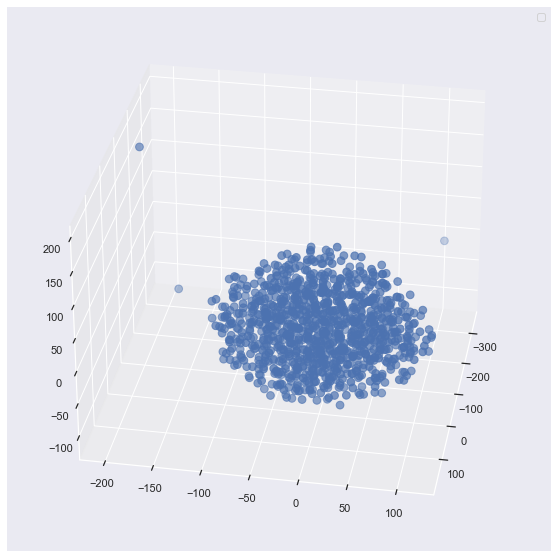

In [139]:
k3_x = [i[0] for i in tsne_df]
k3_y = [i[1] for i in tsne_df]
k3_z = [i[2] for i in tsne_df]


fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(k3_x, k3_y, k3_z, c='b', s=60)

ax.view_init(30, 10)
ax.legend()
plt.show();

No handles with labels found to put in legend.


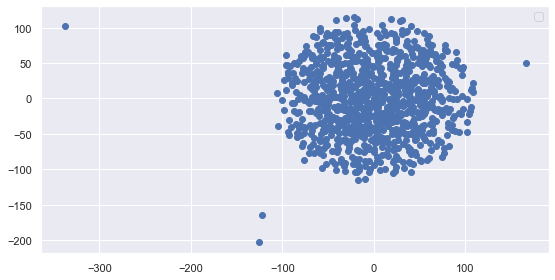

In [125]:
k2_x = [i[0] for i in tsne_df]
k2_y = [i[1] for i in tsne_df]

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(222)
ax.scatter(k2_x, k2_y, c='b')
ax.legend()
plt.show()

In [140]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [143]:
rf =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Random Forest', RandomForestRegressor(max_depth=15, n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features='auto', bootstrap=True))])
svr = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
                ('Linear SVR', LinearSVR(loss='squared_epsilon_insensitive', C=.1, verbose = 10))])
rr = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Ridge Regression', Ridge(alpha=.8))])

In [144]:
models = [('Random Forest', rf),
          ('Support Vector Regression', svr),
          ('Ridge Regression', rr)]

In [146]:
scores = [(name, cross_val_score(model, tokenized, df.value, cv=2, scoring='neg_root_mean_squared_error').mean()) for name, model, in models]

[LibLinear][LibLinear]

In [147]:
scores

[('Random Forest', -527.5605478510056),
 ('Support Vector Regression', -527.7818712630549),
 ('Ridge Regression', -527.7832263802836)]

### Doc2Vec

In [155]:
class Doc2Vectorizer(object):
    
    def __init__(self, d2v):
        # Takes in a dictionary of words and vectors as input
        self.d2v = d2v
        if len(d2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(d2v[next(iter(glove))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.d2v[w] for w in words if w in self.d2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [ ]:
rf_doc2vec =  Pipeline([('Doc2Vec Vectorizer', Doc2Vectorizer(glove)),
              ('Random Forest', RandomForestRegressor(max_depth=15, n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features='auto', bootstrap=True))])

In [ ]:
svr_doc2vec= Pipeline([('Doc2Vec Vectorizer', Doc2Vectorizer(glove)),
                ('Linear SVR', LinearSVR(loss='squared_epsilon_insensitive', C=.1, verbose = 10))])
rr_doc2vec = Pipeline([('Doc2Vec Vectorizer', Doc2Vectorizer(glove)),
              ('Ridge Regression', Ridge(alpha=.8))])

In [17]:
train, test = train_test_split(df, test_size=.30, random_state=54)

In [18]:
#Tag train set
tagged_tr = [TaggedDocument(words=word_tokenize(_d.lower()),
tags=[str(i)]) for i, _d in enumerate(train.answer)]
#Tag test set
tagged_test = [TaggedDocument(words=word_tokenize(_d.lower()),
tags=[str(i)]) for i, _d in enumerate(test.answer)]

In [19]:
model = Doc2Vec(vector_size=100,
                window=5, 
                alpha=.025, 
                min_alpha=0.00025, 
                min_count=2, 
                dm=1, 
                workers=8,
                epochs=40)
model.build_vocab(tagged_tr)

In [20]:
print(f"Word 'country' appeared {model.wv.get_vecattr('country', 'count')} times in the training corpus.")

Word 'country' appeared 5400 times in the training corpus.


In [22]:
model.train(tagged_tr, total_examples=model.corpus_count, epochs=model.epochs)

In [25]:
# Extract training vectors:
X_train = np.array([model.dv[str(i)] for i in range(len(tagged_tr))])
y_train = train['value']

In [24]:
#Use ‘infer_vector’ to generate vectors for the test set:
X_test = np.array([model.infer_vector(tagged_test[i][0]) for i in range(len(tagged_test))])
y_test = test['value']

In [40]:
lr = LinearRegression()
lr_cv = cross_val_score(lr, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

In [41]:
lr_cv

array([-527.02504389, -528.20131526, -527.73603727, -530.20844538,
       -528.19925047])

In [42]:
lr_cv.mean()

-528.2740184534189

In [29]:
rf = RandomForestRegressor(max_depth=15, n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features='auto', bootstrap=True)
rf_cv = cross_val_score(rf, X_train, y_train, cv=2, scoring='neg_root_mean_squared_error')

In [30]:
rf_cv

array([-529.78915515, -531.31147666])

In [34]:
linear_SVR_regressor_verbose = LinearSVR(loss='squared_epsilon_insensitive', C=.1, verbose = 10)
ln_SVR_cv = cross_val_score(linear_SVR_regressor_verbose, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

In [35]:
ln_SVR_cv

array([-527.02492519, -528.20191847, -527.73534852, -530.20764363,
       -528.19906082])

In [39]:
ln_SVR_cv.mean()

-528.2737793267345

In [43]:
rr = Ridge(alpha=.8)
rr_cv = cross_val_score(rr, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

In [44]:
rr_cv

array([-527.02503902, -528.20129066, -527.73604479, -530.20835892,
       -528.19922159])

In [45]:
rr_cv.mean()

-528.2739909939753